In [1]:
%load_ext autoreload
%autoreload 2

# Testcount preprocessing
National/regional holidays can negatively impact the number of performed tests. Also the latest testcount data may be unavailable.

With `covid.data_preprocessing.predict_testcounts`, these testcounts can be predicted using [Facebook Phrophet](https://facebook.github.io/prophet/).

The predictions can interpolate/extrapolate `NaN` values and optionally override/keep the observed testcounts.

In [2]:
from matplotlib import pyplot
import numpy
import os
import pandas
import pathlib
import sys

fp_module = pathlib.Path('..').resolve()
sys.path.append(str(fp_module))

import covid.data
import covid.data_preprocessing

Importing plotly failed. Interactive plots will not work.


## Get input data
The `total` column of the standard `date`-indexed dataframe is used.

In [3]:
df_region = covid.data.get_and_process_covidtracking_data(pandas.Timestamp("2020-07-05")).xs("NY")
df_region.tail()

,positive,total
date,,
2020-06-30,524.0,52025.0
2020-07-01,625.0,56710.0
2020-07-02,875.0,69945.0
2020-07-03,918.0,66392.0
2020-07-04,726.0,62403.0


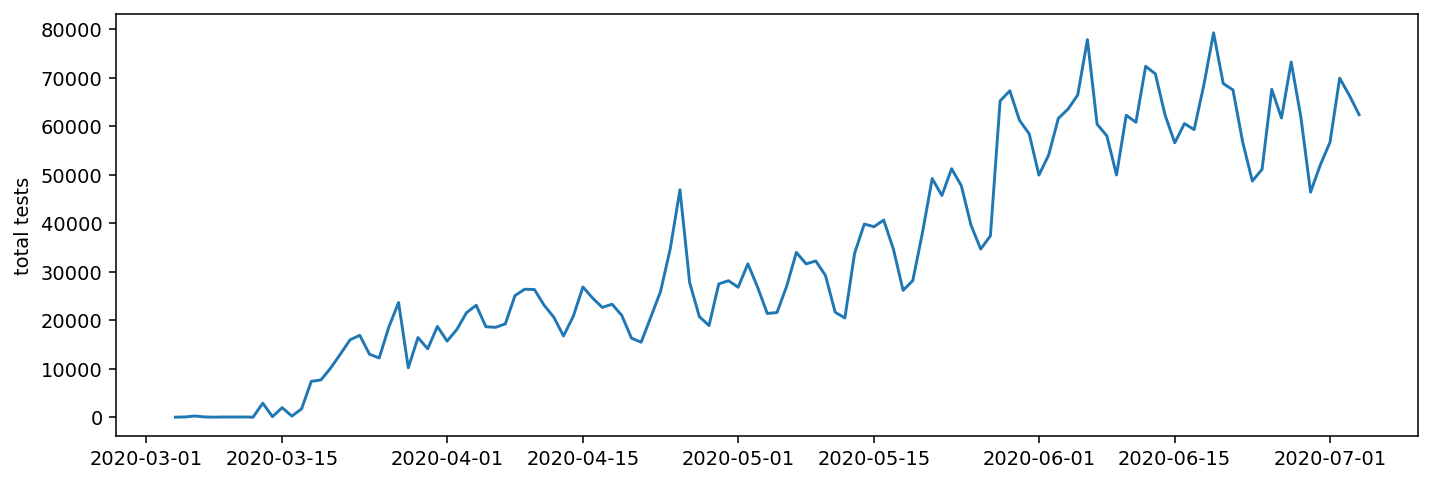

In [4]:
fig, ax = pyplot.subplots(dpi=140, figsize=(12, 4))
ax.plot(df_region.index, df_region.total)
ax.set_ylabel("total tests")
pyplot.show()

## Make the prediction
The prediction is made from the `date`-indexed `total` testcounts.
`country` and `region` must be specified so the function can take national/regional holidays into account.

With `keep_data` one can switch between:
+ `True`: original `total` testcounts are kept
+ `False`: the observations are also predicted (resulting in a smoothed profile)

Optional kwargs are available to adapt to non-reqular patterns in the data:
+ `ignore_before` is used to ignore the ramp-up in test capacity ath the beginning
+ `growth` may be used to switch between a "linear" or "logistic" growth model.

In [5]:
result, m, forecast, holidays = covid.data_preprocessing.predict_testcounts(
    df_region.total,
    country="US", region="NY",
    keep_data=False,
    # optional arguments:
    ignore_before=pandas.Timestamp("2020-04-15"),
)

C:\Users\osthege\AppData\Local\Continuum\miniconda3\envs\airflow-dev\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


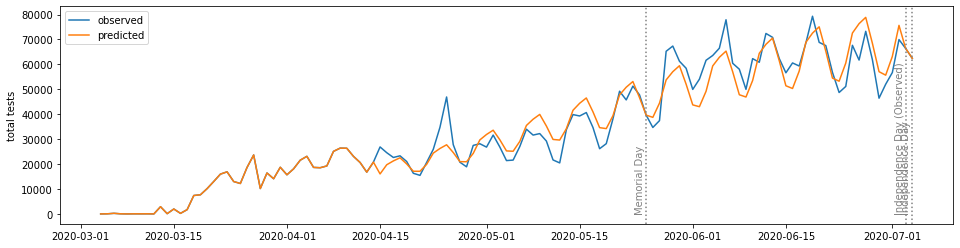

In [6]:
fig, ax = pyplot.subplots(figsize=(16, 4))
ax.plot(df_region.index, df_region.total, label="observed")
ax.plot(df_region.index, result.values, label="predicted")
ymin, ymax = ax.get_ylim()
for date, label in holidays.items():
    if date in list(result.index):
        ax.axvline(date, linestyle=":", color="grey")
        ax.text(
            date,
            ymin * 0.03,
            s=f"{label}\n",
            color="gray",
            rotation=90,
            verticalalignment="bottom",
            horizontalalignment="center",
        )
ax.set_ylabel("total tests")
ax.legend()
pyplot.show()

The `predict_testcounts` function returned the Prophet model and full fitting result (`forecast`). This can be used for a more detailed analysis of the fit:

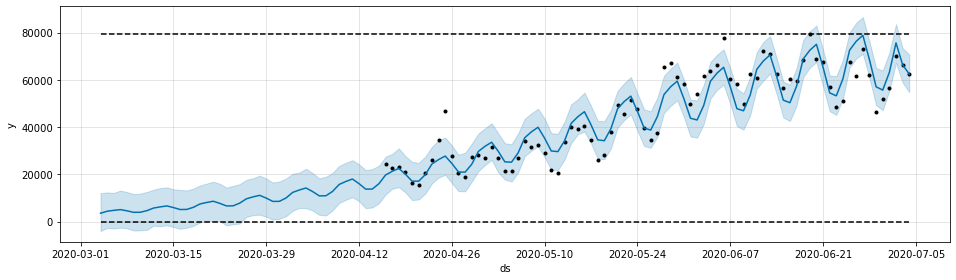

In [7]:
fig, ax = pyplot.subplots(figsize=(13.4, 4))
m.plot(forecast, ax=ax);

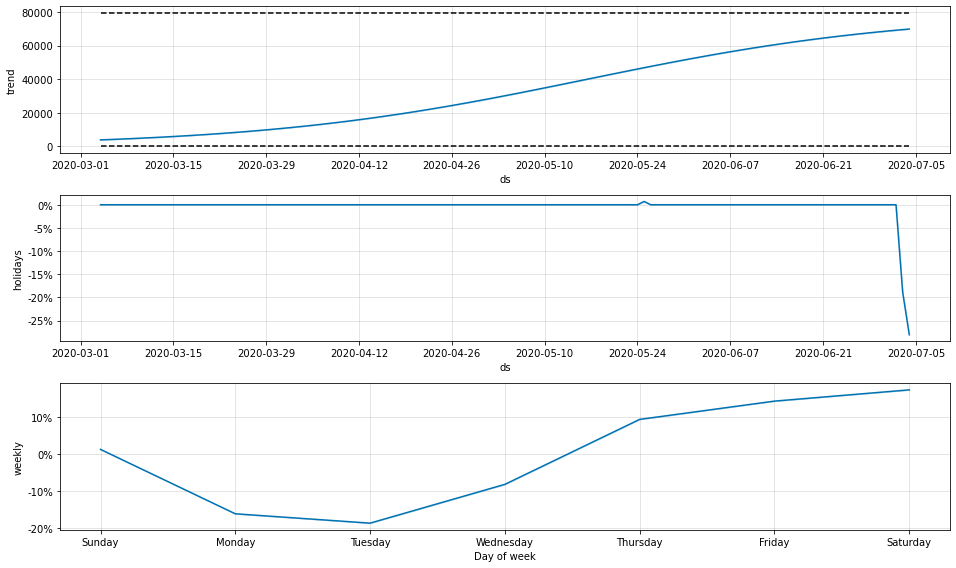

In [8]:
m.plot_components(forecast, figsize=(13.4, 8));